# Visualizations

This notebook contains the code for making visualizations of the data and the forecasting results.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import nbinom
from scipy.optimize import minimize
from scipy.signal import savgol_filter

from functions import GASNegBinIntercept, run_gas_forecast_loop, compute_toto_probs

In [ ]:
data = pd.read_csv("nba_game.csv")
data = data[data['season_type'].isin(['Regular Season', 'Pre Season'])]
# data = data[data['season_type'] == 'Regular Season']
data['game_date'] = pd.to_datetime(data['game_date'], errors='coerce')
data = data[['game_date', 'team_name_home', 'team_name_away', 'pts_home', 'pts_away', 'season_type']]
data = data.dropna()
data['pts_home'] = data['pts_home'].astype(int)
data['pts_away'] = data['pts_away'].astype(int)
data

,game_date,team_name_home,team_name_away,pts_home,pts_away,season_type
0,1946-11-01,Toronto Huskies,New York Knicks,66,68,Regular Season
1,1946-11-02,St. Louis Bombers,Pittsburgh Ironmen,56,51,Regular Season
2,1946-11-02,Providence Steamrollers,Boston Celtics,59,53,Regular Season
3,1946-11-02,Chicago Stags,New York Knicks,63,47,Regular Season
4,1946-11-02,Detroit Falcons,Washington Capitols,33,50,Regular Season
...,...,...,...,...,...,...
65607,2022-10-14,Minnesota Timberwolves,Brooklyn Nets,102,112,Pre Season
65608,2022-10-14,Toronto Raptors,Boston Celtics,137,134,Pre Season
65609,2022-10-14,Indiana Pacers,Houston Rockets,114,122,Pre Season
65610,2022-10-14,New York Knicks,Washington Wizards,105,89,Pre Season


In [3]:
def assign_season(date):
    return f"{date.year}/{date.year + 1}" if date.month >= 7 else f"{date.year - 1}/{date.year}"

def is_weekend(date):
    return date.weekday() >= 5  # Saturday = 5, Sunday = 6

def assign_rounds(season_df):
    season_df = season_df.sort_values("game_date").copy()
    round_counter = 1
    last_type = None
    last_date = None
    round_ids = []

    for date in season_df['game_date']:
        current_type = 'weekend' if is_weekend(date) else 'midweek'
        if last_date is not None:
            days_apart = (date - last_date).days
            if days_apart > 2 or current_type != last_type:
                round_counter += 1

        round_ids.append(round_counter)
        last_date = date
        last_type = current_type

    season_df['round'] = round_ids
    return season_df

In [4]:
data = data[(data['game_date'] >= "2013-07-01") & (data['game_date'] < "2023-06-27")].reset_index() 

# Season
data['season'] = data['game_date'].apply(assign_season)

# Season number
season_order = sorted(data['season'].unique())
season_to_number = {season: i + 1 for i, season in enumerate(season_order)}
data['season_number'] = data['season'].map(season_to_number)

# Assign rounds per season
data = data.groupby('season', group_keys=False).apply(assign_rounds).sort_values('game_date')

In [5]:
# Apply mapping
team_name_mapping = {
    "LA Clippers": "Los Angeles Clippers",
    "Charlotte Hornets": "Charlotte Bobcats"  
}
data['team_name_home'] = data['team_name_home'].replace(team_name_mapping)
data['team_name_away'] = data['team_name_away'].replace(team_name_mapping)

In [6]:
init_data = data[(data['game_date'] >= "2013-10-01") & (data['game_date'] < "2014-05-01")]
train_test_data = data[(data['game_date'] >= "2014-10-01") & (data['game_date'] < "2023-05-01")] 
train_data = train_test_data[(train_test_data['game_date'] >= "2014-10-01") & (train_test_data['game_date'] < "2018-05-01")]
test_data = train_test_data[(train_test_data['game_date'] >= "2018-10-01") & (train_test_data['game_date'] < "2023-05-01")]

In [7]:
all_teams = sorted(
    set(init_data['team_name_home']).union(init_data['team_name_away']) |
    set(train_data['team_name_home']).union(train_data['team_name_away']) |
    set(test_data['team_name_home']).union(test_data['team_name_away'])
)
team_idx = {team: i for i, team in enumerate(all_teams)}
N = len(all_teams)

init_teams = sorted(set(init_data['team_name_home']) | set(init_data['team_name_away']))
init_team_idx = {team: i for i, team in enumerate(init_teams)}
M = len(init_teams)

In [8]:
desc = data[['pts_home', 'pts_away']].describe()
desc = desc.rename(columns={'pts_home': 'Home', 'pts_away': 'Away'})

var_home = data['pts_home'].var()
var_away = data['pts_away'].var()
var_row = pd.DataFrame({'Home': [var_home], 'Away': [var_away]}, index=['var'])

disp_home = var_home / data['pts_home'].mean()
disp_away = var_away / data['pts_away'].mean()

disp_row = pd.DataFrame({'Home': [disp_home], 'Away': [disp_away]}, index=['dispersion'])
ordered_index = ['count', 
                 'mean', 
                 'var', 
                 'std', 
                 'min', 
                 '25%', 
                 '50%', 
                 '75%', 
                 'max']

combined = pd.concat([desc, var_row, disp_row])
combined = combined.loc[ordered_index]
combined = combined.round(2)
combined

,Home,Away
count,12685.00,12685.00
mean,108.35,106.00
var,171.26,174.63
std,13.09,13.21
min,59.00,59.00
25%,99.00,97.00
50%,108.00,106.00
75%,117.00,115.00
max,175.00,176.00


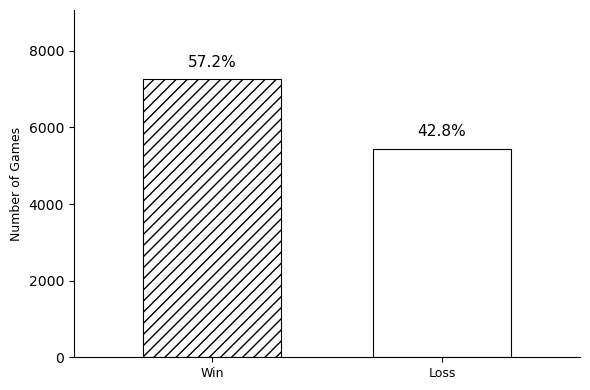

In [9]:
home_wins = (data['pts_home'] > data['pts_away']).sum()
home_losses = (data['pts_home'] < data['pts_away']).sum()
total_games = home_wins + home_losses
outcomes = pd.DataFrame({
    'Result': ['Win', 'Loss'],
    'Count': [home_wins, home_losses],
})
outcomes['Percentage'] = outcomes['Count'] / total_games * 100

x_pos = [0, 1]
bar_width = 0.6
fig, ax = plt.subplots(figsize=(6, 4))  

bars = ax.bar(
    x_pos,
    outcomes['Count'],
    width=bar_width,
    edgecolor='black',
    facecolor='white',
    linewidth=0.8
)

bars[0].set_hatch('///')  
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = outcomes.loc[i, 'Percentage']
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + total_games * 0.02,  
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=11
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(outcomes['Result'], fontsize=9)
ax.set_ylabel('Number of Games', fontsize=9)
ax.set_xlim(-0.6, 1.6)  
ax.set_ylim(0, outcomes['Count'].max() * 1.25)  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='both', direction='out')

plt.tight_layout()
plt.show()

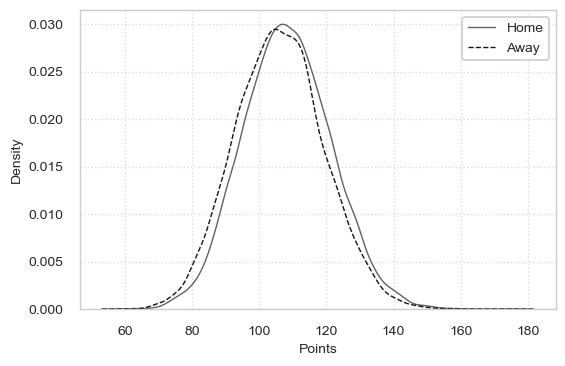

In [10]:
sns.set_context("talk")
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))  

sns.kdeplot(
    data['pts_home'], 
    label='Home', 
    color="#616161",
    linewidth=1,
    ax=ax
)

sns.kdeplot(
    data['pts_away'], 
    label='Away', 
    color="#141414", 
    linewidth=1,
    linestyle='--',
    ax=ax
)

ax.set_xlabel('Points', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(fontsize=10)
ax.grid(True, linestyle=':', alpha=0.7, linewidth=1)

for side in ['top', 'right']:
    ax.spines[side].set_visible(1)  
for side in ['top', 'right', 'left', 'bottom']:
    ax.spines[side].set_linewidth(1)  

plt.tight_layout()
plt.show()

## Latent Strengths

In [11]:
init_data_np = init_data[
    init_data['team_name_home'].isin(init_team_idx)
    & init_data['team_name_away'].isin(init_team_idx)
].copy()
init_data_np['i'] = init_data_np['team_name_home'].map(init_team_idx)
init_data_np['j'] = init_data_np['team_name_away'].map(init_team_idx)

x_vals = init_data_np['pts_home'].values
y_vals = init_data_np['pts_away'].values
i_vals = init_data_np['i'].values
j_vals = init_data_np['j'].values

def log_likelihood(params):
    alpha = params[:M]
    beta = params[M:2 * M]
    delta = params[-3]
    intercept = params[-2]
    log_r = params[-1]
    r = np.exp(log_r)

    mu_home = np.exp(intercept + delta + alpha[i_vals] - beta[j_vals])
    mu_away = np.exp(intercept + alpha[j_vals] - beta[i_vals])

    logpmf_home = nbinom.logpmf(x_vals, r, r / (r + mu_home))
    logpmf_away = nbinom.logpmf(y_vals, r, r / (r + mu_away))

    return -np.sum(logpmf_home + logpmf_away)

def alpha_sum_constraint(params):
    return np.sum(params[:M])

def beta_sum_constraint(params):
    return np.sum(params[M:2 * M])

constraints = [
    {'type': 'eq', 'fun': alpha_sum_constraint},
    {'type': 'eq', 'fun': beta_sum_constraint}
]

params_init = np.zeros(2 * M + 3)
params_init[-3] = 0.04            # delta
params_init[-2] = 3.5             # intercept
params_init[-1] = np.log(250)     # log(r)

result = minimize(
    log_likelihood,
    x0=params_init,
    method='SLSQP',
    constraints=constraints,
    options={'disp': False, 'ftol': 1e-10, 'eps': 1e-8, 'maxiter': 5000}
)
if result.success:
    print("Optimization converged successfully.")
else:
    print("Optimization failed to converge.")

params = result.x
alpha, beta = params[:M], params[M:2 * M]
delta = params[-3]
intercept = params[-2]
log_r = params[-1]
r = np.exp(log_r)

# Map alpha and beta to full vector
alpha_full = np.zeros(N)
beta_full = np.zeros(N)

for team in all_teams:
    idx = team_idx[team]
    if team in init_team_idx:
        j = init_team_idx[team]
        alpha_full[idx] = alpha[j]
        beta_full[idx] = beta[j]

f1_estimate_nb = np.concatenate([alpha_full, beta_full])
print("Finished initialization.")

C:\Users\tcornew\AppData\Local\Temp\ipykernel_10620\1690747859.py:21: RuntimeWarning: overflow encountered in exp
  mu_home = np.exp(intercept + delta + alpha[i_vals] - beta[j_vals])
C:\Users\tcornew\AppData\Local\Temp\ipykernel_10620\1690747859.py:22: RuntimeWarning: overflow encountered in exp
  mu_away = np.exp(intercept + alpha[j_vals] - beta[i_vals])
C:\Users\tcornew\AppData\Local\Temp\ipykernel_10620\1690747859.py:24: RuntimeWarning: invalid value encountered in divide
  logpmf_home = nbinom.logpmf(x_vals, r, r / (r + mu_home))
C:\Users\tcornew\AppData\Local\Temp\ipykernel_10620\1690747859.py:25: RuntimeWarning: invalid value encountered in divide
  logpmf_away = nbinom.logpmf(y_vals, r, r / (r + mu_away))


Optimization converged successfully.
Finished initialization.


In [12]:
model = GASNegBinIntercept(all_teams, f1_estimate=f1_estimate_nb)
model.fit(train_data)

intercept = model.intercept
r = model.r


==== Optimization Results ====
a1=0.0005, a2=0.0004
b1=0.9936, b2=0.9972
delta=0.0251, intercept=4.5796, r=1838.6608
Optimization converged successfully.


In [13]:
forecast_results_nb, latent_history_nb = run_gas_forecast_loop(
    train_test_data=train_test_data,
    test_data=test_data,
    all_teams=all_teams,
    f1_estimate=f1_estimate_nb,
    model_class=GASNegBinIntercept,
    compute_probs_fn=compute_toto_probs,
    distr='negbin'
)


=== Training for season 2018/2019 ===

==== Optimization Results ====
a1=0.0005, a2=0.0004
b1=0.9936, b2=0.9972
delta=0.0251, intercept=4.5796, r=1838.6608
Optimization converged successfully.

=== Forecasting for season 2018/2019 ===

=== Training for season 2019/2020 ===

==== Optimization Results ====
a1=0.0005, a2=0.0004
b1=0.9947, b2=0.9982
delta=0.0251, intercept=4.5802, r=1841.0022
Optimization converged successfully.

=== Forecasting for season 2019/2020 ===

=== Training for season 2020/2021 ===

==== Optimization Results ====
a1=0.0005, a2=0.0004
b1=0.9938, b2=0.9983
delta=0.0246, intercept=4.5826, r=1848.5394
Optimization converged successfully.

=== Forecasting for season 2020/2021 ===

=== Training for season 2021/2022 ===

==== Optimization Results ====
a1=0.0005, a2=0.0004
b1=0.9954, b2=0.9984
delta=0.0222, intercept=4.5808, r=1841.5924
Optimization converged successfully.

=== Forecasting for season 2021/2022 ===

=== Training for season 2022/2023 ===

==== Optimizatio

In [14]:
forecast_df_nb = pd.DataFrame(forecast_results_nb)
latent_df_nb = pd.DataFrame([
    {
        "team": team,
        "date": entry["date"],
        "attack": entry["attack"],
        "defense": entry["defense"],
        "season_type": entry["season_type"]
    }
    for team, entries in latent_history_nb.items()
    for entry in entries
])

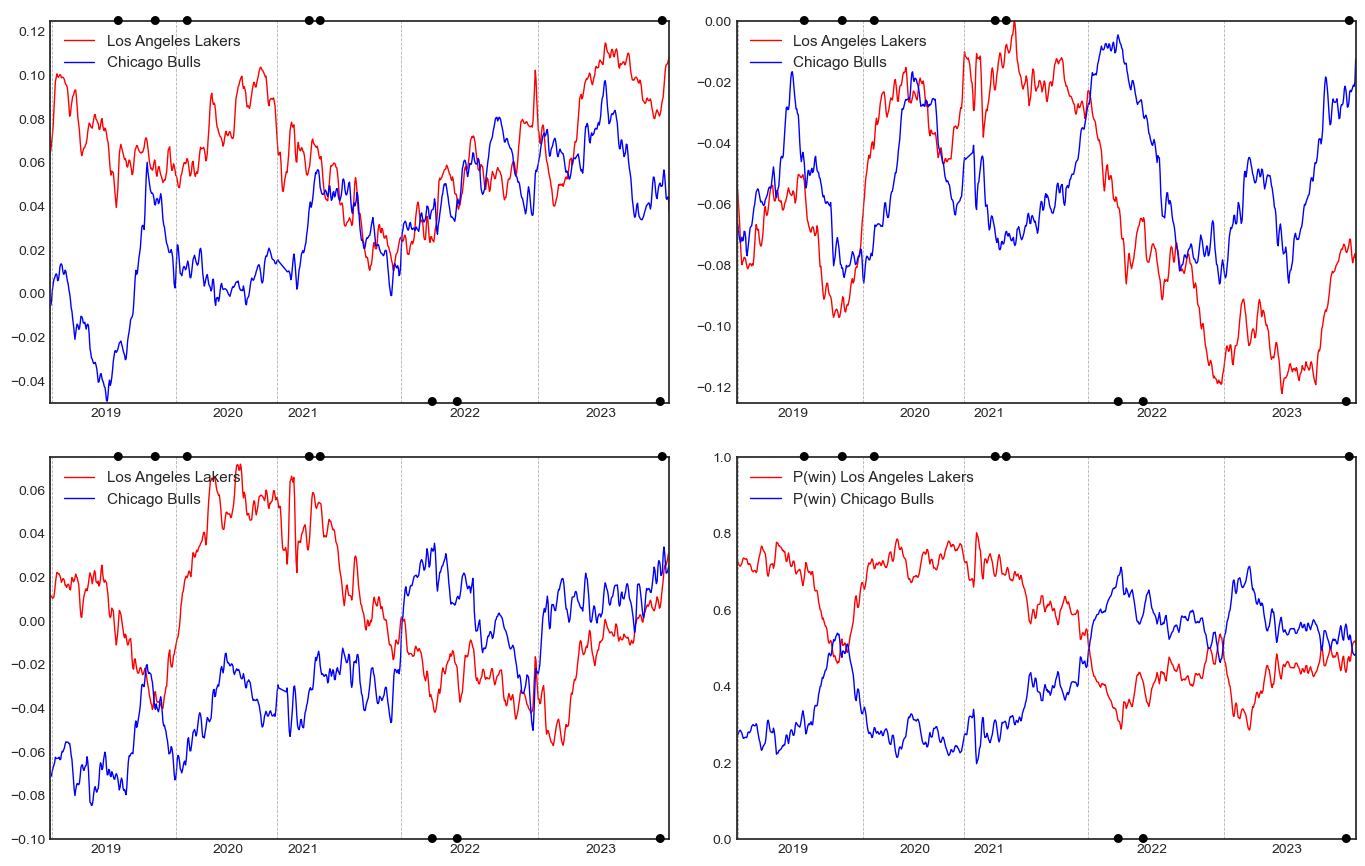

In [15]:
teams_of_interest = ["Los Angeles Lakers", "Chicago Bulls"]
team_colors = {"Los Angeles Lakers": "red", "Chicago Bulls": "blue"}
latent_df_nb = latent_df_nb.sort_values("date")
filtered_latent = latent_df_nb[latent_df_nb["team"].isin(teams_of_interest)].copy()

ref_team = teams_of_interest[0]
ref_df = filtered_latent[filtered_latent["team"] == ref_team].reset_index(drop=True)
ref_df["index"] = ref_df.index
filtered_latent = filtered_latent.merge(ref_df[["date", "index"]], on="date", how="left")

# === Setup plot ===
plt.style.use("seaborn-v0_8-white")
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True)
axes = axes.flatten()
titles = ["Attack Strength", "Defense Strength", "Total Strength", "Toto Probabilities"]

# === Plot latent strengths ===
for team in teams_of_interest:
    df = filtered_latent[filtered_latent["team"] == team].sort_values("index")
    idx = df["index"].values
    atk = savgol_filter(df["attack"].values, 6, 3) if len(df) >= 6 else df["attack"].values
    defn = savgol_filter(df["defense"].values, 6, 3) if len(df) >= 6 else df["defense"].values
    total = atk + defn
    color = team_colors[team]

    axes[0].plot(idx, atk, label=team, linewidth=1, color=color)
    axes[1].plot(idx, defn, label=team, linewidth=1, color=color)
    axes[2].plot(idx, total, label=team, linewidth=1, color=color)

# === Compute and plot Toto probabilities ===
team1_df = filtered_latent[filtered_latent["team"] == teams_of_interest[0]].sort_values("index").reset_index(drop=True)
team2_df = filtered_latent[filtered_latent["team"] == teams_of_interest[1]].sort_values("index").reset_index(drop=True)
min_len = min(len(team1_df), len(team2_df))

prob_indices = []
prob_lakers = []
prob_bulls = []

for i in range(min_len):
    atk1 = team1_df.loc[i, "attack"]
    def2 = team2_df.loc[i, "defense"]
    atk2 = team2_df.loc[i, "attack"]
    def1 = team1_df.loc[i, "defense"]
    idx = team1_df.loc[i, "index"]

    mu1 = np.exp(intercept + atk1 - def2)
    mu2 = np.exp(intercept + atk2 - def1)

    p1, p2, _ = compute_toto_probs(mu_home=mu1, mu_away=mu2, distr='negbin', r=r)
    prob_indices.append(idx)
    prob_lakers.append(p1)
    prob_bulls.append(p2)

prob_lakers = savgol_filter(prob_lakers, 6, 3)
prob_bulls = savgol_filter(prob_bulls, 6, 3)

axes[3].plot(prob_indices, prob_lakers, label="P(win) Los Angeles Lakers", color=team_colors["Los Angeles Lakers"], linewidth=1)
axes[3].plot(prob_indices, prob_bulls, label="P(win) Chicago Bulls", color=team_colors["Chicago Bulls"], linewidth=1)

for ax, title in zip(axes, titles):
    ax.tick_params(labelsize=10)
    legend = ax.legend(
        fontsize=10,
        loc='upper left',
        ncol=1,
        fancybox=False,
    )

# === Set ticks and limits===
ylims = [
    (-0.050, 0.125),   # Attack 
    (-0.125, 0.000),   # Defense 
    (-0.100, 0.075),   # Total 
    (0.0, 1.0)         # Win Probabilities
]
for ax, ylim in zip(axes, ylims):
    ax.set_ylim(ylim)

year_ticks = {
    2019: None,
    2020: None,
    2021: None,
    2022: None,
    2023: None,
    2024: None
}

for year in year_ticks:
    date_match = ref_df[ref_df["date"].dt.year == year]
    jan_match = date_match[date_match["date"].dt.month == 1]
    if not jan_match.empty:
        year_ticks[year] = jan_match.iloc[0]["index"]

xticks = [v for v in year_ticks.values() if v is not None]
xlabels = [str(k) for k, v in year_ticks.items() if v is not None]

xlim_start = ref_df["index"].min()
xlim_end = ref_df["index"].max()

for ax in axes:
    ax.legend(frameon=False, fontsize=11, loc="upper left")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=10, rotation=0)
    ax.tick_params(labelbottom=True)
    ax.set_xlim(xlim_start, xlim_end) 

# === Add black dots for actual Lakers vs Bulls outcomes ===
forecast_df = pd.DataFrame(forecast_results_nb)

mask = (
    ((forecast_df["home_team"] == "Los Angeles Lakers") & (forecast_df["away_team"] == "Chicago Bulls")) |
    ((forecast_df["home_team"] == "Chicago Bulls") & (forecast_df["away_team"] == "Los Angeles Lakers"))
)
head_to_head = forecast_df[mask].copy()
head_to_head = head_to_head.merge(ref_df[["date", "index"]], on="date", how="left")

for _, row in head_to_head.iterrows():
    idx = row["index"]
    if row["true_home"] > row["true_away"]:
        winner = row["home_team"]
    elif row["true_home"] < row["true_away"]:
        winner = row["away_team"]
    else:
        continue  

    for ax in axes:
        y_frac = 1.004 if winner == "Los Angeles Lakers" else 0.005  
        ax.annotate("●", xy=(idx, y_frac), xycoords=("data", "axes fraction"),
                    ha='center', va='center', fontsize=15, color='black', clip_on=False)
        
# === Add vertical lines at the start of each new season ===
def find_nearest_index(date):
    return (ref_df["date"] - date).abs().idxmin()

team_games = data[(data["team_name_home"] == ref_team) | (data["team_name_away"] == ref_team)].copy()

team_games["game_date"] = pd.to_datetime(team_games["game_date"])
ref_df["date"] = pd.to_datetime(ref_df["date"])
season_starts = team_games.sort_values("game_date").groupby("season")["game_date"].first().reset_index()
season_starts["ref_idx"] = season_starts["game_date"].apply(find_nearest_index)
season_starts["plot_index"] = season_starts["ref_idx"].apply(lambda idx: ref_df.loc[idx, "index"])

for ax in axes:
    for x in season_starts["plot_index"]:
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6, alpha=0.6)

plt.tight_layout()
plt.show()